In [1]:
# importing relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import plotly.express as px
import plotly.graph_objs as go

In [19]:
""""latitude,longitude,elevation,utc_offset_seconds,timezone,timezone_abbreviation
31.3884,75.930786,285.0,19800,Asia/Kolkata,IST"""

'"latitude,longitude,elevation,utc_offset_seconds,timezone,timezone_abbreviation\n31.3884,75.930786,285.0,19800,Asia/Kolkata,IST'

## Load and Preprocess Data

In [3]:
punjab_2=pd.read_csv("C:\Desktop\Smart Irrigation System\Punjab_India\PUNJAB_2_open-meteo-31.39N75.93E285m.csv")

In [4]:
"""Dataset for 4 Years ranging from 2020-01-01 to 2023-12-31"""

'Dataset for 4 Years ranging from 2020-01-01 to 2023-12-31'

In [198]:
punjab_2.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature_2m (°C),35064.0,22.644804,7.910950,2.600,16.200,24.200,28.600,43.400
relative_humidity_2m (%),35064.0,68.007158,20.573979,9.000,54.000,72.000,85.000,100.000
precipitation (mm),35064.0,0.098449,0.627933,0.000,0.000,0.000,0.000,26.200
et0_fao_evapotranspiration (mm),35064.0,0.161136,0.200862,0.000,0.010,0.060,0.280,0.890
wind_speed_10m (km/h),35064.0,7.661356,3.917377,0.000,5.100,7.000,9.400,44.900
soil_temperature_28_to_100cm (°C),35064.0,23.213661,5.373268,13.200,18.600,24.300,28.300,31.100
soil_moisture_28_to_100cm (m³/m³),35064.0,0.267997,0.054218,0.143,0.227,0.274,0.308,0.383
shortwave_radiation_instant (W/m²),35064.0,193.618384,265.318839,0.000,0.000,0.000,385.300,949.200


In [43]:
punjab_2.isnull().sum()

time                                  0
temperature_2m (°C)                   0
relative_humidity_2m (%)              0
precipitation (mm)                    0
et0_fao_evapotranspiration (mm)       0
wind_speed_10m (km/h)                 0
soil_temperature_28_to_100cm (°C)     0
soil_moisture_28_to_100cm (m³/m³)     0
shortwave_radiation_instant (W/m²)    0
timestamp                             0
date                                  0
dtype: int64

In [45]:
punjab_2.nunique()

time                                  35064
temperature_2m (°C)                     400
relative_humidity_2m (%)                 92
precipitation (mm)                      104
et0_fao_evapotranspiration (mm)          89
wind_speed_10m (km/h)                   301
soil_temperature_28_to_100cm (°C)       180
soil_moisture_28_to_100cm (m³/m³)       240
shortwave_radiation_instant (W/m²)     7492
timestamp                             35064
date                                   1461
dtype: int64

### Converting from hourly to daily

In [5]:

# Convert timestamp to datetime
punjab_2['timestamp'] = pd.to_datetime(punjab_2['time'])

# Extract date
punjab_2['date'] = punjab_2['timestamp'].dt.date

# Aggregate to daily data
punjab_daily_data = punjab_2.groupby('date').agg({
    'temperature_2m (°C)': 'mean',
    'relative_humidity_2m (%)': 'mean',
    'precipitation (mm)': 'sum',
    'et0_fao_evapotranspiration (mm)': 'sum',
    'wind_speed_10m (km/h)': 'mean',
    'soil_temperature_28_to_100cm (°C)': 'mean',
    'soil_moisture_28_to_100cm (m³/m³)': 'mean',
    'shortwave_radiation_instant (W/m²)': 'sum'
}).reset_index()


In [206]:
punjab_daily_data.head(3)

,date,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),et0_fao_evapotranspiration (mm),wind_speed_10m (km/h),soil_temperature_28_to_100cm (°C),soil_moisture_28_to_100cm (m³/m³),shortwave_radiation_instant (W/m²)
0,2020-01-01,9.795833,87.666667,0.0,1.54,5.179167,13.508333,0.3265,2948.4
1,2020-01-02,11.625000,77.166667,0.0,1.63,6.362500,13.475000,0.3260,2763.3
2,2020-01-03,11.620833,79.250000,0.0,1.78,5.908333,13.591667,0.3240,3124.3


In [207]:
punjab_daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   date                                1461 non-null   object 
 1   temperature_2m (°C)                 1461 non-null   float64
 2   relative_humidity_2m (%)            1461 non-null   float64
 3   precipitation (mm)                  1461 non-null   float64
 4   et0_fao_evapotranspiration (mm)     1461 non-null   float64
 5   wind_speed_10m (km/h)               1461 non-null   float64
 6   soil_temperature_28_to_100cm (°C)   1461 non-null   float64
 7   soil_moisture_28_to_100cm (m³/m³)   1461 non-null   float64
 8   shortwave_radiation_instant (W/m²)  1461 non-null   float64
dtypes: float64(8), object(1)
memory usage: 102.9+ KB


In [6]:
# Rename ET₀ column for easier reference
punjab_daily_data.rename(columns={'et0_fao_evapotranspiration (mm)': 'ET₀ (mm)'}, inplace=True)

In [209]:
punjab_strealit_historical=punjab_daily_data.copy()

In [210]:
punjab_strealit_historical

,date,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),ET₀ (mm),wind_speed_10m (km/h),soil_temperature_28_to_100cm (°C),soil_moisture_28_to_100cm (m³/m³),shortwave_radiation_instant (W/m²)
0,2020-01-01,9.795833,87.666667,0.0,1.54,5.179167,13.508333,0.326500,2948.4
1,2020-01-02,11.625000,77.166667,0.0,1.63,6.362500,13.475000,0.326000,2763.3
2,2020-01-03,11.620833,79.250000,0.0,1.78,5.908333,13.591667,0.324000,3124.3
3,2020-01-04,11.125000,79.375000,0.0,1.72,5.850000,13.745833,0.322875,3087.0
4,2020-01-05,11.533333,73.166667,0.0,1.57,7.258333,13.891667,0.323000,2597.2
...,...,...,...,...,...,...,...,...,...
1456,2023-12-27,13.225000,82.791667,0.0,1.79,6.195833,16.533333,0.268208,2933.2
1457,2023-12-28,11.479167,92.083333,0.0,1.40,3.870833,16.475000,0.278417,2592.1
1458,2023-12-29,12.008333,92.083333,0.0,1.52,5.300000,16.333333,0.286042,2731.4
1459,2023-12-30,11.716667,90.708333,0.0,1.40,5.100000,16.270833,0.287917,2456.7


In [9]:
"""Define the crop coefficient (Kc) values for different growth stages of wheat:"""

'Define the crop coefficient (Kc) values for different growth stages of wheat:'

In [10]:
""""
In Punjab, the growing season for wheat typically aligns with the winter months and early spring. The specific timing can vary slightly based on local climate and agricultural practices, but generally, the growing season for wheat in Punjab spans from:

Sowing: October to November
Harvesting: March to April"""

'"\nIn Punjab, the growing season for wheat typically aligns with the winter months and early spring. The specific timing can vary slightly based on local climate and agricultural practices, but generally, the growing season for wheat in Punjab spans from:\n\nSowing: October to November\nHarvesting: March to April'

In [11]:
""""The crop coefficient (Kc) for wheat varies depending on the growth stage of the crop. Here are the typical Kc values for wheat during different growth stages, as recommended by the FAO:

1. *Initial Stage (Germination to Early Growth):* 0.3 - 0.4
2. *Crop Development Stage:* 0.7 - 0.8
3. *Mid-Season Stage (Booting to Grain Filling):* 1.0 - 1.2
4. *Late Season Stage (Ripening):* 0.6 - 0.8

### Detailed Kc Values for Wheat

1. *Initial Stage:*
   - *Duration:* Approximately 20-30 days
   - *Kc Value:* 0.3 - 0.4
   - *Description:* This stage includes germination and the early growth of the wheat plants. Water requirements are relatively low.

2. *Crop Development Stage:*
   - *Duration:* Approximately 30-40 days
   - *Kc Value:* 0.7 - 0.8
   - *Description:* This stage includes the development of the wheat crop, where water needs increase as the plants grow rapidly.

3. *Mid-Season Stage:*
   - *Duration:* Approximately 40-60 days
   - *Kc Value:* 1.0 - 1.2
   - *Description:* This is the peak growth period, including booting, heading, and grain filling. Water requirements are highest during this stage.

4. *Late Season Stage:*
   - *Duration:* Approximately 30-40 days
   - *Kc Value:* 0.6 - 0.8
   - *Description:* This stage includes maturation and ripening of the wheat crop. Water needs decrease as the crop approaches harvest.

"""

'"The crop coefficient (Kc) for wheat varies depending on the growth stage of the crop. Here are the typical Kc values for wheat during different growth stages, as recommended by the FAO:\n\n1. *Initial Stage (Germination to Early Growth):* 0.3 - 0.4\n2. *Crop Development Stage:* 0.7 - 0.8\n3. *Mid-Season Stage (Booting to Grain Filling):* 1.0 - 1.2\n4. *Late Season Stage (Ripening):* 0.6 - 0.8\n\n### Detailed Kc Values for Wheat\n\n1. *Initial Stage:*\n   - *Duration:* Approximately 20-30 days\n   - *Kc Value:* 0.3 - 0.4\n   - *Description:* This stage includes germination and the early growth of the wheat plants. Water requirements are relatively low.\n\n2. *Crop Development Stage:*\n   - *Duration:* Approximately 30-40 days\n   - *Kc Value:* 0.7 - 0.8\n   - *Description:* This stage includes the development of the wheat crop, where water needs increase as the plants grow rapidly.\n\n3. *Mid-Season Stage:*\n   - *Duration:* Approximately 40-60 days\n   - *Kc Value:* 1.0 - 1.2\n   - *

In [12]:
"""ETc represents the total amount of water lost from the soil surface through evaporation and from the plant through transpiration over a specific period, usually expressed in millimeters (mm)."""

'ETc represents the total amount of water lost from the soil surface through evaporation and from the plant through transpiration over a specific period, usually expressed in millimeters (mm).'

In [211]:
# Check the column names in the DataFrame
print(punjab_daily_data.columns)


Index(['date', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'precipitation (mm)', 'ET₀ (mm)', 'wind_speed_10m (km/h)',
       'soil_temperature_28_to_100cm (°C)',
       'soil_moisture_28_to_100cm (m³/m³)',
       'shortwave_radiation_instant (W/m²)'],
      dtype='object')


In [ ]:
punjab_daily_data

# EDA

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


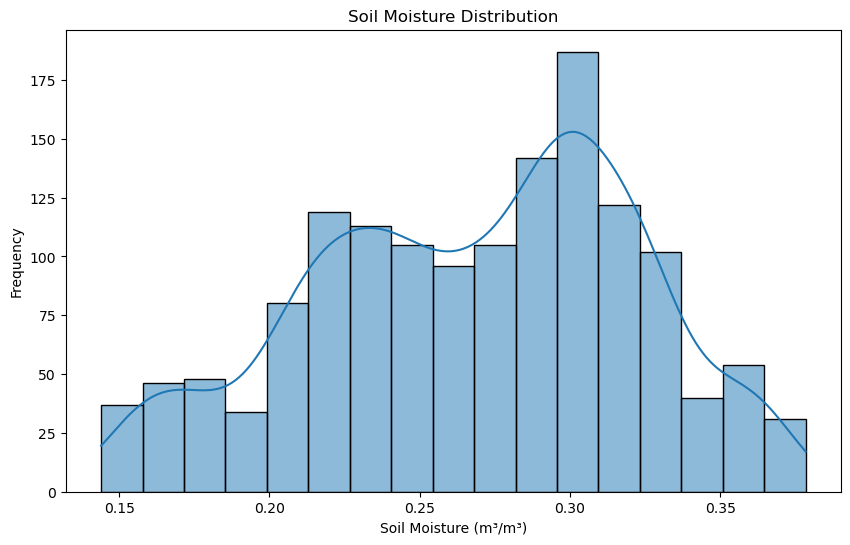

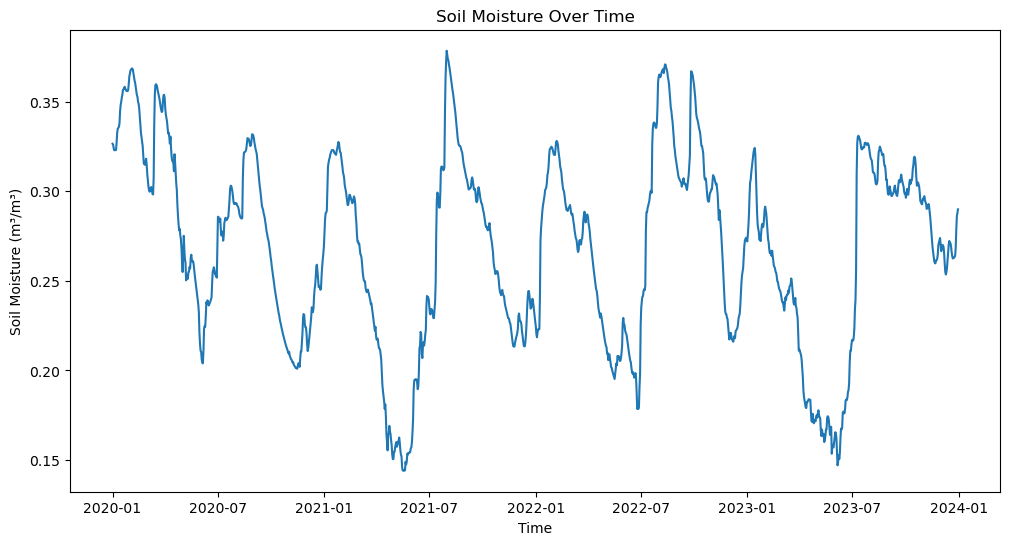

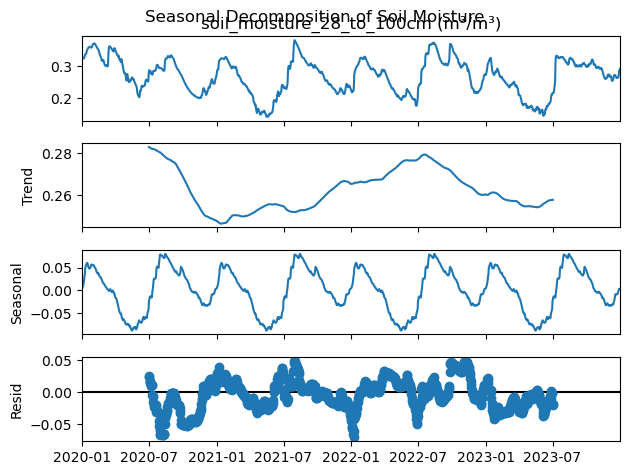

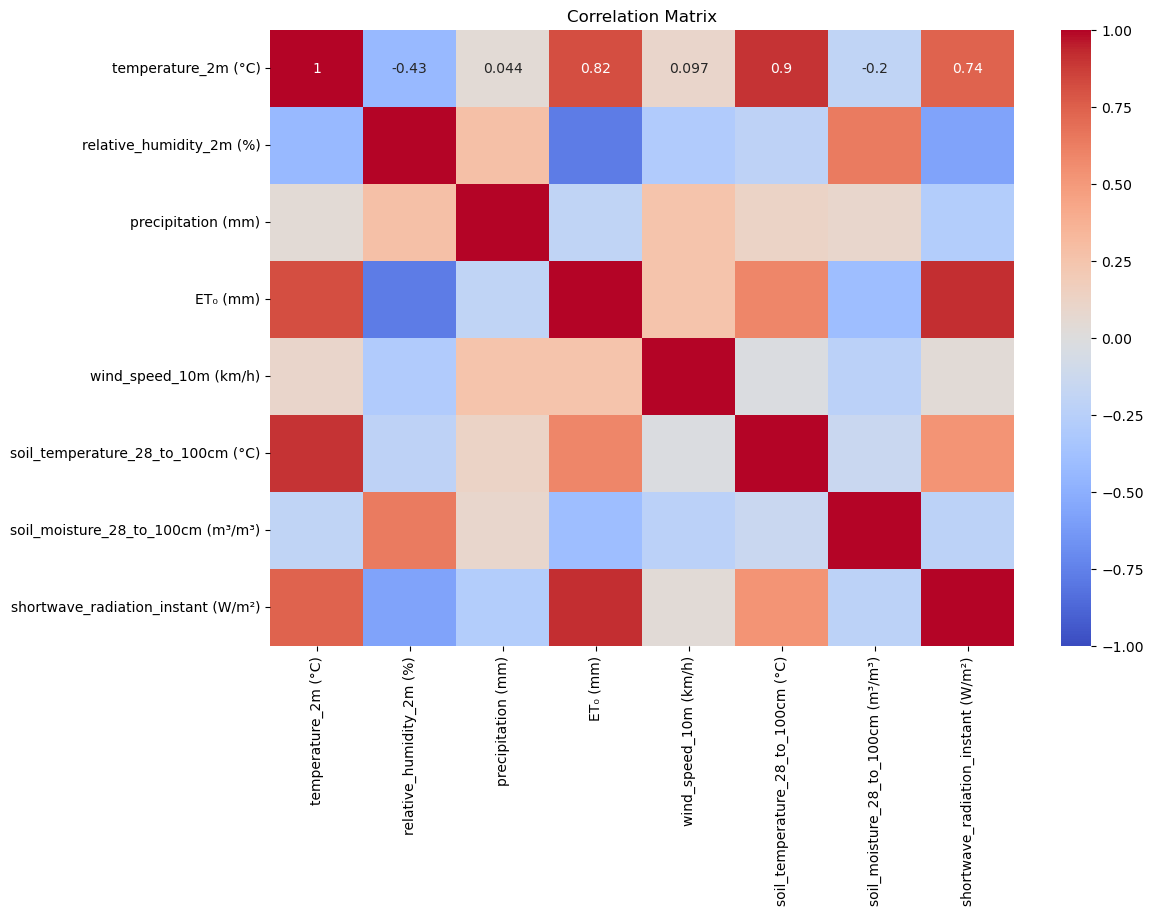

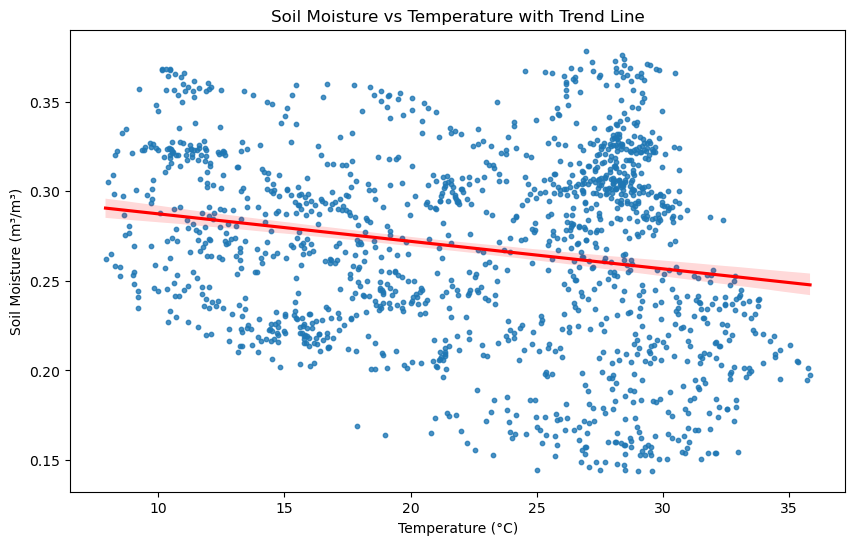

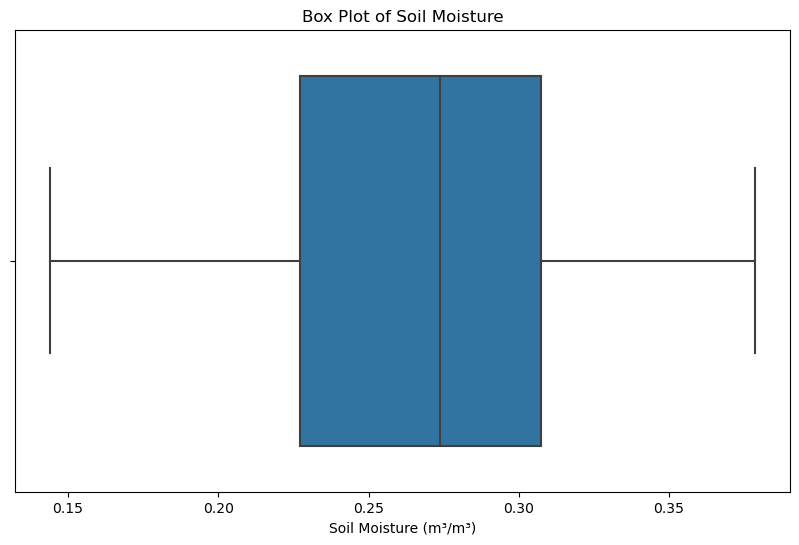

In [7]:

# Convert 'date' column to datetime and set as index
#punjab_daily_data['date'] = pd.to_datetime(punjab_daily_data['date'])
punjab_daily_data.set_index('date', inplace=True)


plt.figure(figsize=(10, 6))
sns.histplot(punjab_daily_data['soil_moisture_28_to_100cm (m³/m³)'], kde=True)
plt.title('Soil Moisture Distribution')
plt.xlabel('Soil Moisture (m³/m³)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(punjab_daily_data.index, punjab_daily_data['soil_moisture_28_to_100cm (m³/m³)'])
plt.title('Soil Moisture Over Time')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (m³/m³)')
plt.show()


decomposition = seasonal_decompose(punjab_daily_data['soil_moisture_28_to_100cm (m³/m³)'], model='additive', period=365)
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Soil Moisture')
plt.show()

#Correlation Analysis (Heatmap)
numeric_cols = punjab_daily_data.select_dtypes(include=[np.number]).columns
corr_matrix = punjab_daily_data[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


# Scatter plot with trend line: Soil Moisture vs Temperature
plt.figure(figsize=(10, 6))
sns.regplot(x='temperature_2m (°C)', y='soil_moisture_28_to_100cm (m³/m³)', data=punjab_daily_data, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Soil Moisture vs Temperature with Trend Line')
plt.xlabel('Temperature (°C)')
plt.ylabel('Soil Moisture (m³/m³)')
plt.show()


# Anomaly detection: Box plot for soil moisture
plt.figure(figsize=(10, 6))
sns.boxplot(x=punjab_daily_data['soil_moisture_28_to_100cm (m³/m³)'])
plt.title('Box Plot of Soil Moisture')
plt.xlabel('Soil Moisture (m³/m³)')
plt.show()


## Distrubtion Analysis

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


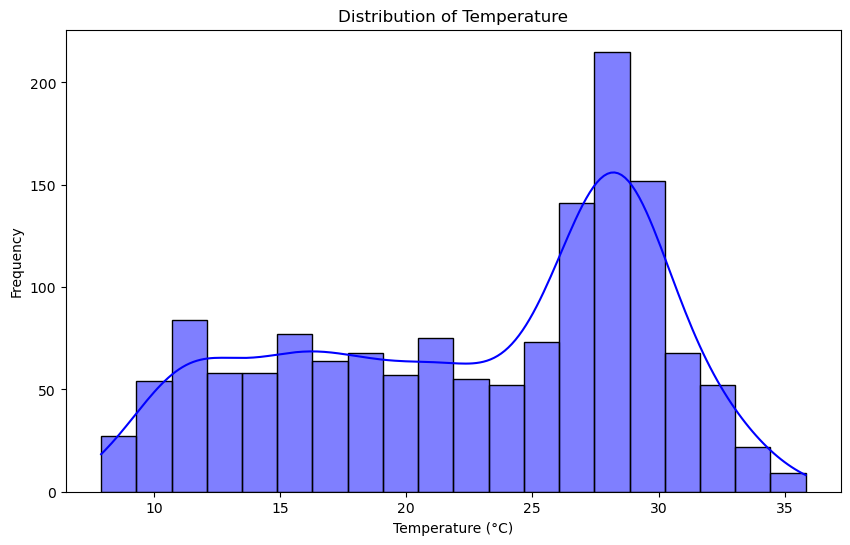

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


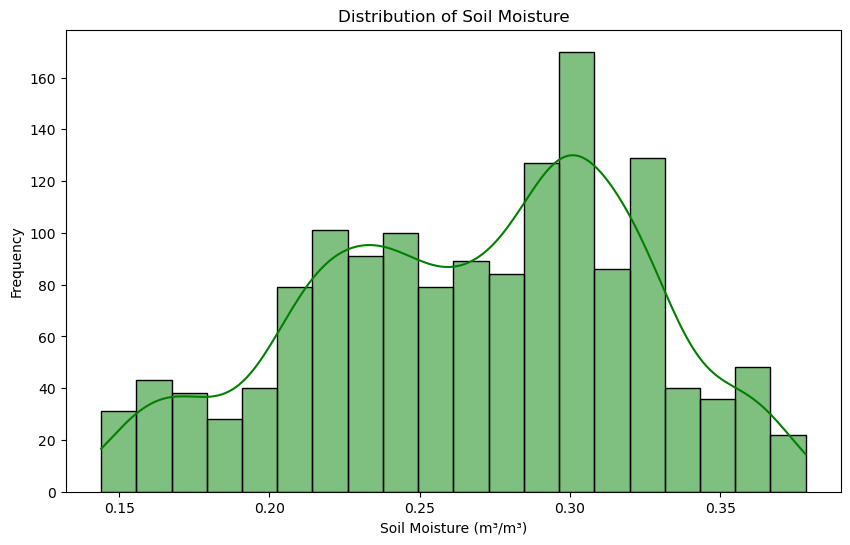

In [8]:
# Plot histograms for selected columns
plt.figure(figsize=(10, 6))
sns.histplot(punjab_daily_data['temperature_2m (°C)'], kde=True, color='blue', bins=20)
plt.title('Distribution of Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(punjab_daily_data['soil_moisture_28_to_100cm (m³/m³)'], kde=True, color='green', bins=20)
plt.title('Distribution of Soil Moisture')
plt.xlabel('Soil Moisture (m³/m³)')
plt.ylabel('Frequency')
plt.show()


## Visualizing Time series data

In [9]:
fig = px.line(punjab_daily_data, x=punjab_daily_data.index, y='soil_moisture_28_to_100cm (m³/m³)', title='Soil Moisture Over Time')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Soil Moisture (m³/m³)')
fig.show()


## Seasonal Decomposition

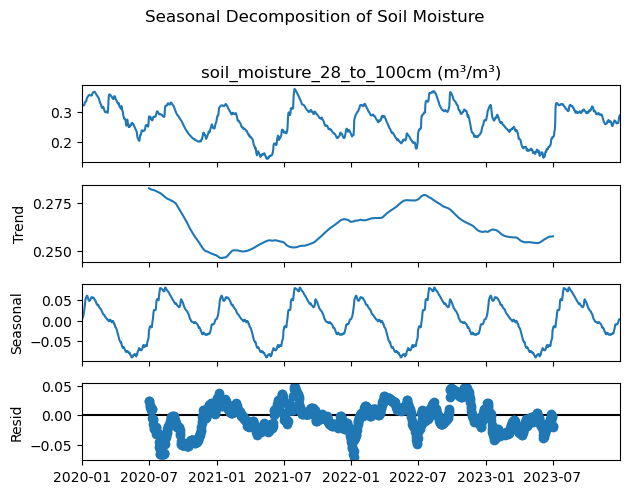

In [10]:
# Perform seasonal decomposition on soil moisture data
decomposition = seasonal_decompose(punjab_daily_data['soil_moisture_28_to_100cm (m³/m³)'], model='additive', period=365)

# Plot decomposition with adjusted title position
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Soil Moisture', y=1.02)  # Adjust the y value for title position
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [11]:
#punjab.set_index('Time', inplace=True)

# Create a Plotly figure using plotly.express
fig = px.line(punjab_daily_data, x=punjab_daily_data.index, y='temperature_2m (°C)', title='Temperature Over Time')

# Update x-axis and y-axis titles
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Temperature_2m (°C))')

# Show the figure
fig.show()

In [12]:
#punjab.set_index('Time', inplace=True)

# Create a Plotly figure using plotly.express
fig = px.line(punjab_daily_data, x=punjab_daily_data.index, y='precipitation (mm)', title='Precipitation Over Time')

# Update x-axis and y-axis titles
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Precipitation (mm)	')

# Show the figure
fig.show()

In [13]:
#punjab_daily_data.set_index('Time', inplace=True)

# Create a Plotly figure using plotly.express
fig = px.line(punjab_daily_data, x=punjab_daily_data.index, y="soil_temperature_28_to_100cm (°C)", title="Soil Temperature Over Time")

# Update x-axis and y-axis titles
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Soil_temperature_28_to_100cm (°C)')

# Show the figure
fig.show()

In [14]:
#punjab.set_index('Time', inplace=True)

# Create a Plotly figure using plotly.express
fig = px.line(punjab_daily_data, x=punjab_daily_data.index, y='wind_speed_10m (km/h)', title='(Wind speed Over Time')

# Update x-axis and y-axis titles
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Wind_speed_10m (km/h)')

# Show the figure
fig.show()

In [15]:


#punjab.set_index('Time', inplace=True)

# Create a Plotly figure using plotly.express
fig = px.line(punjab_daily_data, x=punjab_daily_data.index, y='relative_humidity_2m (%)', title='(Relaive humidity Over Time')

# Update x-axis and y-axis titles
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Relative_humidity_2m (%)')

# Show the figure
fig.show()

## Scatter Plot

In [44]:
"""Scatter plots are useful for visualizing relationships between two continuous variables. They can help identify patterns, correlations, and outliers"""

'Scatter plots are useful for visualizing relationships between two continuous variables. They can help identify patterns, correlations, and outliers'

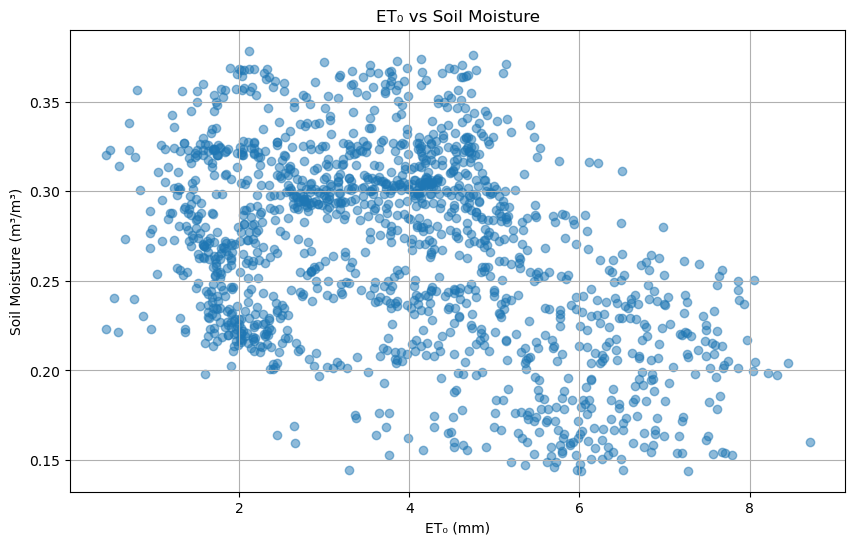

In [16]:
# Scatter plot: ET₀ vs Soil Moisture
plt.figure(figsize=(10, 6))
plt.scatter(punjab_daily_data['ET₀ (mm)'], punjab_daily_data['soil_moisture_28_to_100cm (m³/m³)'], alpha=0.5)
plt.title('ET₀ vs Soil Moisture')
plt.xlabel('ET₀ (mm)')
plt.ylabel('Soil Moisture (m³/m³)')
plt.grid(True)
plt.show()


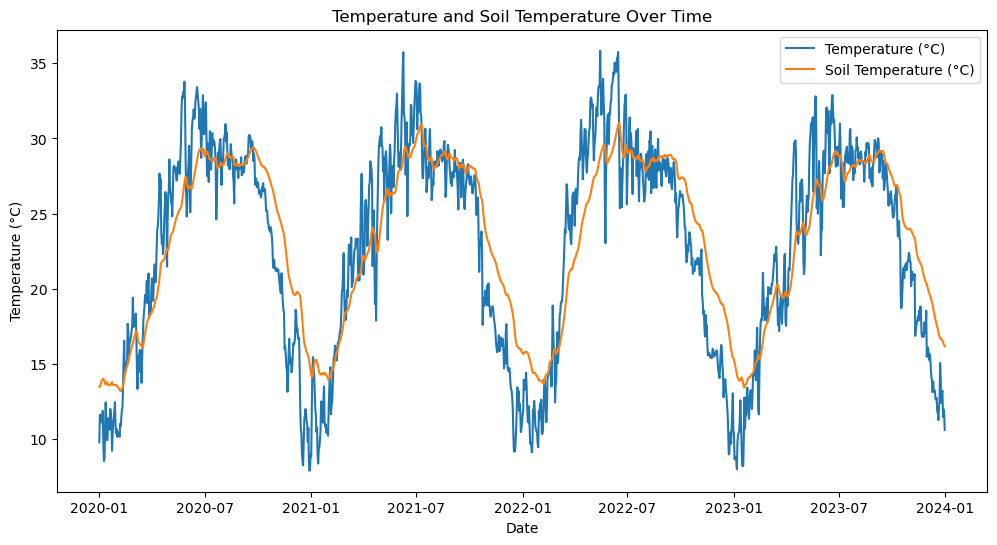

In [17]:
# Line plot: Temperature and Soil Temperature
plt.figure(figsize=(12, 6))
plt.plot(punjab_daily_data.index, punjab_daily_data['temperature_2m (°C)'], label='Temperature (°C)')
plt.plot(punjab_daily_data.index, punjab_daily_data['soil_temperature_28_to_100cm (°C)'], label='Soil Temperature (°C)')
plt.title('Temperature and Soil Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



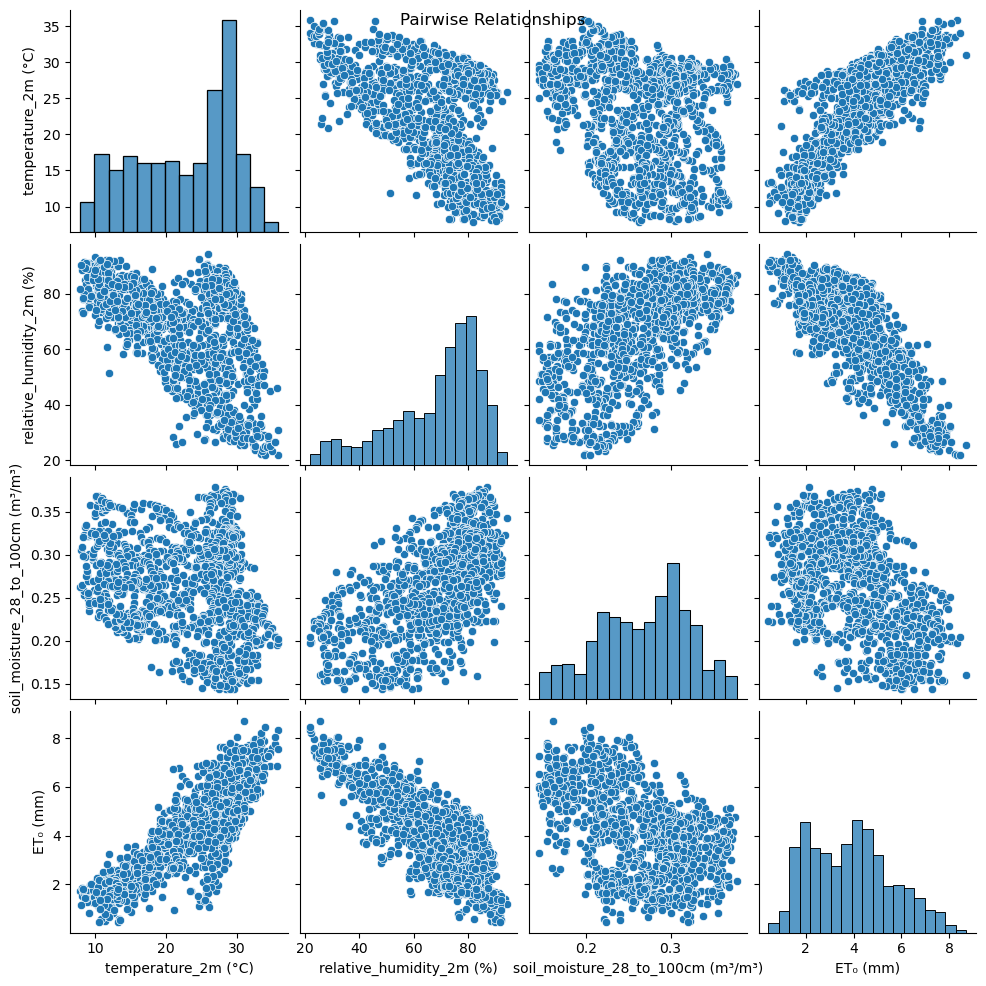

In [18]:
# Pair plot: Pairwise relationships
sns.pairplot(punjab_daily_data[['temperature_2m (°C)', 'relative_humidity_2m (%)', 'soil_moisture_28_to_100cm (m³/m³)', 'ET₀ (mm)']])
plt.suptitle('Pairwise Relationships')
plt.show()


In [25]:
punjab_daily_data

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),ET₀ (mm),wind_speed_10m (km/h),soil_temperature_28_to_100cm (°C),soil_moisture_28_to_100cm (m³/m³),shortwave_radiation_instant (W/m²)
date,,,,,,,,
2020-01-01,9.795833,87.666667,0.0,1.54,5.179167,13.508333,0.326500,2948.4
2020-01-02,11.625000,77.166667,0.0,1.63,6.362500,13.475000,0.326000,2763.3
2020-01-03,11.620833,79.250000,0.0,1.78,5.908333,13.591667,0.324000,3124.3
2020-01-04,11.125000,79.375000,0.0,1.72,5.850000,13.745833,0.322875,3087.0
2020-01-05,11.533333,73.166667,0.0,1.57,7.258333,13.891667,0.323000,2597.2
...,...,...,...,...,...,...,...,...
2023-12-27,13.225000,82.791667,0.0,1.79,6.195833,16.533333,0.268208,2933.2
2023-12-28,11.479167,92.083333,0.0,1.40,3.870833,16.475000,0.278417,2592.1
2023-12-29,12.008333,92.083333,0.0,1.52,5.300000,16.333333,0.286042,2731.4


Index(['temperature_2m (°C)', 'relative_humidity_2m (%)', 'precipitation (mm)',
       'ET₀ (mm)', 'wind_speed_10m (km/h)',
       'soil_temperature_28_to_100cm (°C)',
       'soil_moisture_28_to_100cm (m³/m³)',
       'shortwave_radiation_instant (W/m²)'],
      dtype='object')


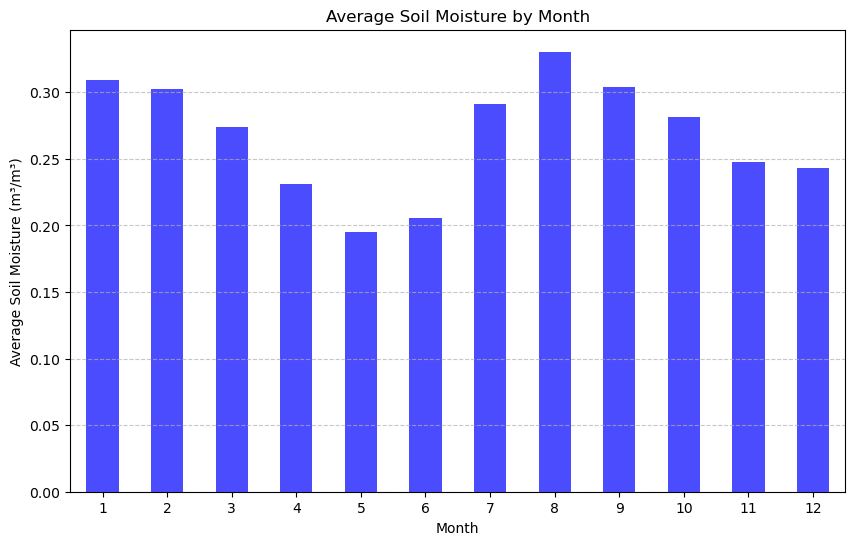

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming punjab_daily_data is already loaded with the provided dataset
# Print the current column names to identify the correct column containing dates
print(punjab_daily_data.columns)
# Convert index to datetime if it's not already
punjab_daily_data.index = pd.to_datetime(punjab_daily_data.index)
# Assuming the index of punjab_daily_data is already in datetime format
# Calculate monthly average soil moisture
punjab_daily_data['month'] = punjab_daily_data.index.month
average_soil_moisture_by_month = punjab_daily_data.groupby('month')['soil_moisture_28_to_100cm (m³/m³)'].mean()

# Plotting average soil moisture by month
plt.figure(figsize=(10, 6))
average_soil_moisture_by_month.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Average Soil Moisture by Month')
plt.xlabel('Month')
plt.ylabel('Average Soil Moisture (m³/m³)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


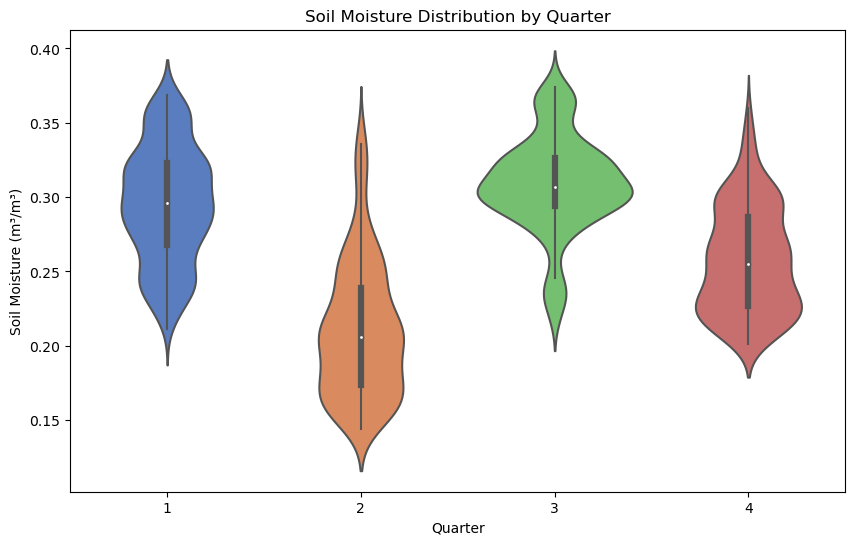

In [31]:
# Violin plot: Soil Moisture by Season (quarter)
punjab_daily_data['quarter'] = punjab_daily_data.index.quarter

plt.figure(figsize=(10, 6))
sns.violinplot(x=punjab_daily_data['quarter'], y=punjab_daily_data['soil_moisture_28_to_100cm (m³/m³)'], palette='muted')
plt.title('Soil Moisture Distribution by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Soil Moisture (m³/m³)')
plt.show()


# Loading Future Data for Testing

In [127]:
import pandas as pd

# Load the CSV file with proper date parsing
present_data_with_forecast_data = pd.read_csv(r"C:\Desktop\Smart Irrigation System\present_data_with_forecast_data.csv", parse_dates=['Unnamed: 0'])

# Set the datetime column as the index
present_data_with_forecast_data.set_index('Unnamed: 0', inplace=True)

# Rename the index to 'date' if needed
present_data_with_forecast_data.index.name = 'date'

# Print or inspect the DataFrame
present_data_with_forecast_data


,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),ET₀ (mm),wind_speed_10m (km/h),soil_temperature_28_to_100cm (°C),soil_moisture_28_to_100cm (m³/m³),shortwave_radiation_instant (W/m²)
date,,,,,,,,
2024-01-01,10.329167,91.083333,0.000000,1.320000,5.645833,16.095833,0.290250,2388.300000
2024-01-02,9.212500,92.333333,0.000000,1.060000,5.116667,15.958333,0.291750,1955.000000
2024-01-03,9.412500,92.000000,0.000000,1.270000,4.408333,15.779167,0.292500,2389.900000
2024-01-04,9.387500,89.291667,0.000000,1.440000,5.187500,15.604167,0.291708,2643.800000
2024-01-05,8.641667,89.791667,0.000000,1.330000,5.312500,15.391667,0.295375,2596.100000
...,...,...,...,...,...,...,...,...
2024-07-01,35.501951,26.349423,5.569302,6.033347,10.377087,31.633761,0.177156,4456.106014
2024-07-02,35.426123,25.623231,4.075754,6.199416,10.247070,31.667406,0.177709,4657.509156
2024-07-03,34.989782,27.020121,5.425977,6.051022,9.915974,31.686460,0.177413,4573.618413


# Crop   Evapotranspiration Calculation

In [128]:
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv
import os
import psycopg2

# Load environment variables from .env file
load_dotenv()

# Define growth stages with typical Kc ranges for different crops
growth_stages = {
    'Wheat': [],
    'Rice': [],
    'Maize': [],
    'Sugarcane': [],
    'Cotton': [],
    'Barley': [],
    'Potatoes': [],
    'Pulses': []
}

# Define growth stages and Kc values for Wheat
growth_stages['Wheat'].extend([
    {'start': '2023-10-01', 'end': '2023-10-30', 'Kc': 0.35, 'stage': 'Initial'},
    {'start': '2023-11-01', 'end': '2023-12-10', 'Kc': 0.75, 'stage': 'Crop Development'},
    {'start': '2023-12-11', 'end': '2024-02-10', 'Kc': 1.1, 'stage': 'Heading & Grain filling'},
    {'start': '2024-02-11', 'end': '2024-04-10', 'Kc': 0.7, 'stage': 'Maturity & Ripening'}
])

# Define growth stages for Rice
growth_stages['Rice'].extend([
    {'start': '2023-11-11', 'end': '2024-01-10', 'Kc': 1.2, 'stage': 'Heading & Grain filling'},
    {'start': '2024-01-11', 'end': '2024-03-10', 'Kc': 0.8, 'stage': 'Maturity & Ripening'}
])

# Define growth stages for Maize
growth_stages['Maize'].extend([
    {'start': '2023-10-21', 'end': '2023-12-10', 'Kc': 1.2, 'stage': 'Heading & Grain filling'},
    {'start': '2023-12-11', 'end': '2024-02-10', 'Kc': 0.7, 'stage': 'Maturity & Ripening'}
])

# Define growth stages for Sugarcane
growth_stages['Sugarcane'].extend([
    {'start': '2023-10-01', 'end': '2023-12-31', 'Kc': 0.4, 'stage': 'Initial'},
    {'start': '2024-01-01', 'end': '2024-03-31', 'Kc': 0.85, 'stage': 'Tillering and Shooting'},
    {'start': '2024-04-01', 'end': '2024-09-30', 'Kc': 1.2, 'stage': 'Canopy Development'},
    {'start': '2024-10-01', 'end': '2024-12-31', 'Kc': 0.75, 'stage': 'Maturity & Ripening'}
])

# Define growth stages for Cotton
growth_stages['Cotton'].extend([
    {'start': '2024-04-01', 'end': '2024-05-31', 'Kc': 0.45, 'stage': 'Initial'},
    {'start': '2024-06-01', 'end': '2024-07-31', 'Kc': 0.75, 'stage': 'Crop Development'},
    {'start': '2024-08-01', 'end': '2024-10-31', 'Kc': 1.15, 'stage': 'Flowering & Boll Development'},
    {'start': '2024-11-01', 'end': '2024-12-31', 'Kc': 0.75, 'stage': 'Maturity'}
])

# Define growth stages for Barley
growth_stages['Barley'].extend([
    {'start': '2023-10-01', 'end': '2023-10-30', 'Kc': 0.3, 'stage': 'Initial'},
    {'start': '2023-11-01', 'end': '2023-12-10', 'Kc': 0.7, 'stage': 'Crop Development'},
    {'start': '2023-12-11', 'end': '2024-02-10', 'Kc': 1.15, 'stage': 'Heading & Grain filling'},
    {'start': '2024-02-11', 'end': '2024-04-10', 'Kc': 0.7, 'stage': 'Maturity & Ripening'}
])

# Define growth stages for Potatoes
growth_stages['Potatoes'].extend([
    {'start': '2024-01-01', 'end': '2024-02-29', 'Kc': 0.5, 'stage': 'Initial'},
    {'start': '2024-03-01', 'end': '2024-04-30', 'Kc': 0.8, 'stage': 'Crop Development'},
    {'start': '2024-05-01', 'end': '2024-06-30', 'Kc': 1.15, 'stage': 'Tuber Formation'},
    {'start': '2024-07-01', 'end': '2024-08-31', 'Kc': 0.75, 'stage': 'Maturity'}
])

# Define growth stages for Pulses
growth_stages['Pulses'].extend([
    {'start': '2023-10-01', 'end': '2023-10-30', 'Kc': 0.4, 'stage': 'Initial'},
    {'start': '2023-11-01', 'end': '2023-12-10', 'Kc': 0.7, 'stage': 'Crop Development'},
    {'start': '2023-12-11', 'end': '2024-02-10', 'Kc': 1.05, 'stage': 'Flowering and Pod Development'},
    {'start': '2024-02-11', 'end': '2024-04-10', 'Kc': 0.8, 'stage': 'Pod Filling and Maturation'}
])

# Function to get Kc value and growth stage based on the crop and date
def get_kc_stage(crop, date):
    if crop in growth_stages:
        for stage in growth_stages[crop]:
            start_date = pd.to_datetime(stage['start'])
            end_date = pd.to_datetime(stage['end'])
            if start_date <= date <= end_date:
                return stage['Kc'], stage['stage']
    return 0.35, 'Unknown'  # Default Kc and stage if crop or date doesn't match any stage

# Function to process dataframe for each crop
def process_crop_data(df, crop_name):
    df['crop'] = crop_name
    df[['Kc', 'growth_stage']] = df.apply(lambda row: pd.Series(get_kc_stage(row['crop'], row['date'])), axis=1)
    df['ETc (mm)'] = df['ET₀ (mm)'] * df['Kc']
    return df

# Reset index to make 'date' a column
present_data_with_forecast_data.reset_index(inplace=True)
# Convert date column to datetime format
present_data_with_forecast_data['date'] = pd.to_datetime(present_data_with_forecast_data['date'])

# Create dataframe for each crop
wheat_data = process_crop_data(present_data_with_forecast_data.copy(), 'Wheat')
rice_data = process_crop_data(present_data_with_forecast_data.copy(), 'Rice')
maize_data = process_crop_data(present_data_with_forecast_data.copy(), 'Maize')
sugarcane_data = process_crop_data(present_data_with_forecast_data.copy(), 'Sugarcane')
cotton_data = process_crop_data(present_data_with_forecast_data.copy(), 'Cotton')
barley_data = process_crop_data(present_data_with_forecast_data.copy(), 'Barley')
potatoes_data = process_crop_data(present_data_with_forecast_data.copy(), 'Potatoes')
pulses_data = process_crop_data(present_data_with_forecast_data.copy(), 'Pulses')


In [ ]:
wheat_data.head(2)

In [ ]:
print("\nWheat Data:")
wheat_data.head()

In [ ]:
print("\nRice Data:")
rice_data.head()



In [ ]:
# Display the first few rows of each crop-specific DataFrame
print("Maize Data:")
maize_data.head()


In [ ]:
# Display the first few rows of each crop-specific DataFrame
print("Sugarcane Data:")
sugarcane_data.head()



In [ ]:
# Display the first few rows of each crop-specific DataFrame
print("Cotton Data:")
cotton_data.head()

In [ ]:
# Display the first few rows of each crop-specific DataFrame
print("Barley Data:")
barley_data.head()

In [ ]:
# Display the first few rows of each crop-specific DataFrame
print("Potatoes Data:")
potatoes_data.head()

In [ ]:
# Display the first few rows of each crop-specific DataFrame
print("Pulses Data:")
pulses_data.head()

In [16]:
present_data_with_forecast_data.describe().T

,count,mean,min,25%,50%,75%,max,std
date,187,2024-04-03 00:00:00,2024-01-01 00:00:00,2024-02-16 12:00:00,2024-04-03 00:00:00,2024-05-19 12:00:00,2024-07-05 00:00:00,NaN
temperature_2m (°C),187.0,23.082168,7.204167,13.835417,24.254167,32.941667,37.8625,9.706351
relative_humidity_2m (%),187.0,50.107621,11.791667,27.741922,46.083333,70.583333,92.666667,24.176841
precipitation (mm),187.0,1.319068,-3.911261,0.0,0.0,0.05,46.2,5.193667
ET₀ (mm),187.0,4.935422,0.11,2.615,5.22,6.935,9.5,2.462196
wind_speed_10m (km/h),187.0,9.152005,4.054167,7.4375,8.908333,10.37396,26.041667,3.058857
soil_temperature_28_to_100cm (°C),187.0,21.624899,12.8125,15.545833,21.0125,27.989583,32.1,6.733248
soil_moisture_28_to_100cm (m³/m³),187.0,0.220757,0.163,0.180937,0.202583,0.245542,0.33225,0.052131
shortwave_radiation_instant (W/m²),187.0,4921.571972,0.0,3848.05,5214.9,6230.65,6967.7,1469.710872


# Soil Deficit Determination and Crop Irrigation need Calculation

In [41]:
"""Wheat"""

'Wheat'

In [ ]:
threshold_soil_moisture = 0.220757		  # Example threshold in m³/m³(which is mean of soil moisture in the Dataset)
# Calculate soil deficit
wheat_data['soil_deficit(mm)'] = wheat_data['ETc (mm)'] - wheat_data['precipitation (mm)']
wheat_data['irrigation_need'] = wheat_data['soil_moisture_28_to_100cm (m³/m³)'] < threshold_soil_moisture
#wheat_data['date'] = pd.to_datetime(wheat_data['date'])
def calculate_irrigation_need(soil_moisture, threshold, soil_deficit):
    if soil_moisture < threshold:
        return max(0, threshold - soil_moisture + soil_deficit)
    return 0

wheat_data['irrigation_amount(mm)'] = wheat_data.apply(lambda row: calculate_irrigation_need(
    row['soil_moisture_28_to_100cm (m³/m³)'], threshold_soil_moisture, row['soil_deficit(mm)']), axis=1)

# Create an irrigation schedule
irrigation_schedule = wheat_data[wheat_data['irrigation_need'] == True][['date', 'irrigation_amount(mm)','growth_stage']]
irrigation_schedule


In [139]:
irrigation_schedule.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 55 to 186
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               132 non-null    datetime64[ns]
 1   irrigation_amount  132 non-null    float64       
 2   growth_stage       132 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.1+ KB


In [ ]:
# Create an irrigation schedule within the growing season of Maize
irrigation_schedule_wheat = wheat_data[(wheat_data['date'] >= '2023-10-01') & 
                                              (wheat_data['date'] <= '2024-04-10') & 
                                              (wheat_data['irrigation_amount(mm)'] > 0)][['date', 'irrigation_amount(mm)','growth_stage']]

# Display the resulting irrigation schedule
wheat_irrigation_schedule=irrigation_schedule_wheat.reset_index(drop=True)
wheat_irrigation_schedule.info()

In [ ]:
wheat_irrigation_schedule

In [18]:
"""Rice"""

'Rice'

In [ ]:
threshold_soil_moisture = 0.220757	  # Example threshold in m³/m³(which is mean of soil moisture in the Dataset)
# Calculate soil deficit
rice_data['soil_deficit(mm)'] = rice_data['ETc (mm)'] - rice_data['precipitation (mm)']
rice_data['irrigation_need'] = rice_data['soil_moisture_28_to_100cm (m³/m³)'] < threshold_soil_moisture
#rice_data['date'] = pd.to_datetime(rice_data['date'])
def calculate_irrigation_need(soil_moisture, threshold, soil_deficit):
    if soil_moisture < threshold:
        return max(0, threshold - soil_moisture + soil_deficit)
    return 0

rice_data['irrigation_amount(mm)'] = rice_data.apply(lambda row: calculate_irrigation_need(
    row['soil_moisture_28_to_100cm (m³/m³)'], threshold_soil_moisture, row['soil_deficit(mm)']), axis=1)

# Create an irrigation schedule
irrigation_schedule = rice_data[rice_data['irrigation_need'] == True][['date', 'irrigation_amount(mm)','growth_stage']]

irrigation_schedule


In [171]:
# Create an irrigation schedule within the growing season of Maize
irrigation_schedule_rice = rice_data[(rice_data['date'] >= '2023-11-11') & 
                                              (rice_data['date'] <= '2024-03-10') & 
                                              (rice_data['irrigation_amount(mm)'] > 0)][['date', 'irrigation_amount(mm)','growth_stage']]


# Display the resulting irrigation schedule
rice_irrigation_schedule=irrigation_schedule_rice.reset_index(drop=True)
rice_irrigation_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   13 non-null     datetime64[ns]
 1   irrigation_amount(mm)  13 non-null     float64       
 2   growth_stage           13 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 440.0+ bytes


In [ ]:
rice_irrigation_schedule

In [22]:
"""Maize"""

'Maize'

In [ ]:
threshold_soil_moisture = 0.220757	  # Example threshold in m³/m³(which is mean of soil moisture in the Dataset)
# Calculate soil deficit
maize_data['soil_deficit(mm)'] = maize_data['ETc (mm)'] - maize_data['precipitation (mm)']
maize_data['irrigation_need'] = maize_data['soil_moisture_28_to_100cm (m³/m³)'] < threshold_soil_moisture
#maize_data['date'] = pd.to_datetime(maize_data['date'])
def calculate_irrigation_need(soil_moisture, threshold, soil_deficit):
    if soil_moisture < threshold:
        return max(0, threshold - soil_moisture + soil_deficit)
    return 0

maize_data['irrigation_amount(mm)'] = maize_data.apply(lambda row: calculate_irrigation_need(
    row['soil_moisture_28_to_100cm (m³/m³)'], threshold_soil_moisture, row['soil_deficit(mm)']), axis=1)

# Create an irrigation schedule
irrigation_schedule = maize_data[maize_data['irrigation_need'] == True][['date', 'irrigation_amount(mm)','growth_stage']]
irrigation_schedule


In [ ]:
maize_data.head(4)

In [173]:
# Create an irrigation schedule within the growing season of Maize
irrigation_schedule_maize = maize_data[(maize_data['date'] >= '2023-10-21') & 
                                              (maize_data['date'] <= '2024-02-10') & 
                                              (maize_data['irrigation_amount(mm)'] > 0)][['date', 'irrigation_amount(mm)','growth_stage']]


# Display the resulting irrigation schedule
maize_irrigation_schedule=irrigation_schedule_maize.reset_index(drop=True)
maize_irrigation_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   0 non-null      datetime64[ns]
 1   irrigation_amount(mm)  0 non-null      float64       
 2   growth_stage           0 non-null      object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 124.0+ bytes


In [17]:
"""Sugarcane"""

'Sugarcane'

In [ ]:
threshold_soil_moisture = 0.220757	  # Example threshold in m³/m³(which is mean of soil moisture in the Dataset)
# Calculate soil deficit
sugarcane_data['soil_deficit(mm)'] = sugarcane_data['ETc (mm)'] - sugarcane_data['precipitation (mm)']
sugarcane_data['irrigation_need'] = sugarcane_data['soil_moisture_28_to_100cm (m³/m³)'] < threshold_soil_moisture
#sugarcane_data['date'] = pd.to_datetime(sugarcane_data['date'])
def calculate_irrigation_need(soil_moisture, threshold, soil_deficit):
    if soil_moisture < threshold:
        return max(0, threshold - soil_moisture + soil_deficit)
    return 0

sugarcane_data['irrigation_amount(mm)'] = sugarcane_data.apply(lambda row: calculate_irrigation_need(
    row['soil_moisture_28_to_100cm (m³/m³)'], threshold_soil_moisture, row['soil_deficit(mm)']), axis=1)

# Create an irrigation schedule
irrigation_schedule = sugarcane_data[sugarcane_data['irrigation_need'] == True][['date', 'irrigation_amount(mm)','growth_stage']]

irrigation_schedule


In [175]:
# Create an irrigation schedule within the growing season of sugarcane
irrigation_schedule_sugarcane = sugarcane_data[(sugarcane_data['date'] >= '2023-10-21') & 
                                              (sugarcane_data['date'] <= '2024-12-31') & 
                                              (sugarcane_data['irrigation_amount(mm)'] > 0)][['date', 'irrigation_amount(mm)','growth_stage']]


# Display the resulting irrigation schedule
sugarcane_irrigation_schedule=irrigation_schedule_sugarcane.reset_index(drop=True)
sugarcane_irrigation_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   125 non-null    datetime64[ns]
 1   irrigation_amount(mm)  125 non-null    float64       
 2   growth_stage           125 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.1+ KB


In [21]:
"""Cotton"""

'Cotton'

In [ ]:
threshold_soil_moisture = 0.220757	  # Example threshold in m³/m³(which is mean of soil moisture in the Dataset)
# Calculate soil deficit
cotton_data['soil_deficit(mm)'] = cotton_data['ETc (mm)'] - cotton_data['precipitation (mm)']
cotton_data['irrigation_need'] = cotton_data['soil_moisture_28_to_100cm (m³/m³)'] < threshold_soil_moisture
#cotton_data['date'] = pd.to_datetime(cotton_data['date'])
def calculate_irrigation_need(soil_moisture, threshold, soil_deficit):
    if soil_moisture < threshold:
        return max(0, threshold - soil_moisture + soil_deficit)
    return 0

cotton_data['irrigation_amount(mm)'] = cotton_data.apply(lambda row: calculate_irrigation_need(
    row['soil_moisture_28_to_100cm (m³/m³)'], threshold_soil_moisture, row['soil_deficit(mm)']), axis=1)

# Create an irrigation schedule
irrigation_schedule = cotton_data[cotton_data['irrigation_need'] == True][['date', 'irrigation_amount(mm)','growth_stage']]

irrigation_schedule


In [177]:
# Create an irrigation schedule within the growing season of sugarcane
irrigation_schedule_cotton = cotton_data[(cotton_data['date'] >= '2024-04-01') & 
                                              (cotton_data['date'] <= '2024-12-31') & 
                                              (cotton_data['irrigation_amount(mm)'] > 0)][['date', 'irrigation_amount(mm)','growth_stage']]


# Display the resulting irrigation schedule
cotton_irrigation_schedule=irrigation_schedule_cotton.reset_index(drop=True)
cotton_irrigation_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   86 non-null     datetime64[ns]
 1   irrigation_amount(mm)  86 non-null     float64       
 2   growth_stage           86 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.1+ KB


In [26]:
"""Barley"""

'Barley'

In [ ]:
threshold_soil_moisture = 0.220757	  # Example threshold in m³/m³(which is mean of soil moisture in the Dataset)
# Calculate soil deficit
barley_data['soil_deficit(mm)'] = barley_data['ETc (mm)'] - barley_data['precipitation (mm)']
barley_data['irrigation_need'] = barley_data['soil_moisture_28_to_100cm (m³/m³)'] < threshold_soil_moisture
#barley_data['date'] = pd.to_datetime(barley_data['date'])
def calculate_irrigation_need(soil_moisture, threshold, soil_deficit):
    if soil_moisture < threshold:
        return max(0, threshold - soil_moisture + soil_deficit)
    return 0

barley_data['irrigation_amount(mm)'] = barley_data.apply(lambda row: calculate_irrigation_need(
    row['soil_moisture_28_to_100cm (m³/m³)'], threshold_soil_moisture, row['soil_deficit(mm)']), axis=1)

# Create an irrigation schedule
irrigation_schedule = barley_data[barley_data['irrigation_need'] == True][['date', 'irrigation_amount(mm)','growth_stage']]

irrigation_schedule


In [179]:
# Create an irrigation schedule within the growing season of sugarcane
irrigation_schedule_barley = barley_data[(barley_data['date'] >= '2023-10-01') & 
                                              (barley_data['date'] <= '2024-04-10') & 
                                              (barley_data['irrigation_amount(mm)'] > 0)][['date', 'irrigation_amount(mm)','growth_stage']]


# Display the resulting irrigation schedule
barley_irrigation_schedule=irrigation_schedule_barley.reset_index(drop=True)
barley_irrigation_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   42 non-null     datetime64[ns]
 1   irrigation_amount(mm)  42 non-null     float64       
 2   growth_stage           42 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.1+ KB


In [30]:
"""Potatoes"""

'Potatoes'

In [ ]:
threshold_soil_moisture = 0.220757	  # Example threshold in m³/m³(which is mean of soil moisture in the Dataset)
# Calculate soil deficit
potatoes_data['soil_deficit(mm)'] = potatoes_data['ETc (mm)'] - potatoes_data['precipitation (mm)']
potatoes_data['irrigation_need'] = potatoes_data['soil_moisture_28_to_100cm (m³/m³)'] < threshold_soil_moisture
#potatoes_data['date'] = pd.to_datetime(potatoes_data['date'])
def calculate_irrigation_need(soil_moisture, threshold, soil_deficit):
    if soil_moisture < threshold:
        return max(0, threshold - soil_moisture + soil_deficit)
    return 0

potatoes_data['irrigation_amount(mm)'] = potatoes_data.apply(lambda row: calculate_irrigation_need(
    row['soil_moisture_28_to_100cm (m³/m³)'], threshold_soil_moisture, row['soil_deficit(mm)']), axis=1)

# Create an irrigation schedule
irrigation_schedule = potatoes_data[potatoes_data['irrigation_need'] == True][['date', 'irrigation_amount(mm)','growth_stage']]

irrigation_schedule


In [181]:
# Create an irrigation schedule within the growing season of sugarcane
irrigation_schedule_potatoes = potatoes_data[(potatoes_data['date'] >= '2024-01-01') & 
                                              (potatoes_data['date'] <= '2024-08-31') & 
                                              (potatoes_data['irrigation_amount(mm)'] > 0)][['date', 'irrigation_amount(mm)','growth_stage']]


# Display the resulting irrigation schedule
potatoes_irrigation_schedule=irrigation_schedule_potatoes.reset_index(drop=True)
potatoes_irrigation_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   123 non-null    datetime64[ns]
 1   irrigation_amount(mm)  123 non-null    float64       
 2   growth_stage           123 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.0+ KB


In [35]:
"""Pulses"""

'Pulses'

In [ ]:
threshold_soil_moisture = 0.220757	  # Example threshold in m³/m³(which is mean of soil moisture in the Dataset)
# Calculate soil deficit
pulses_data['soil_deficit(mm)'] = pulses_data['ETc (mm)'] - pulses_data['precipitation (mm)']
pulses_data['irrigation_need'] = pulses_data['soil_moisture_28_to_100cm (m³/m³)'] < threshold_soil_moisture
#pulses_data['date'] = pd.to_datetime(pulses_data['date'])
def calculate_irrigation_need(soil_moisture, threshold, soil_deficit):
    if soil_moisture < threshold:
        return max(0, threshold - soil_moisture + soil_deficit)
    return 0

pulses_data['irrigation_amount(mm)'] = pulses_data.apply(lambda row: calculate_irrigation_need(
    row['soil_moisture_28_to_100cm (m³/m³)'], threshold_soil_moisture, row['soil_deficit(mm)']), axis=1)

# Create an irrigation schedule
irrigation_schedule = pulses_data[pulses_data['irrigation_need'] == True][['date', 'irrigation_amount(mm)','growth_stage']]

irrigation_schedule


In [183]:
# Create an irrigation schedule within the growing season of sugarcane
irrigation_schedule_pulses = pulses_data[(pulses_data['date'] >= '2023-10-01') & 
                                              (pulses_data['date'] <= '2024-04-10') & 
                                              (pulses_data['irrigation_amount(mm)'] > 0)][['date', 'irrigation_amount(mm)','growth_stage']]


# Display the resulting irrigation schedule
pulses_irrigation_schedule=irrigation_schedule_pulses.reset_index(drop=True)
pulses_irrigation_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   43 non-null     datetime64[ns]
 1   irrigation_amount(mm)  43 non-null     float64       
 2   growth_stage           43 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.1+ KB


# Database Creation

In [38]:
"""Creating table for Historcal data (2020 to 2023)"""

'Creating table for Historcal data (2020 to 2023)'

In [ ]:
# make sure to load dotenv
from dotenv import load_dotenv
import os
import psycopg2
load_dotenv()

# Database connection paramete(s
Database_URL = os.getenv('DataBase_Url')

#connect to database
conn = psycopg2.connect(Database_URL)
cur = conn.cursor()

#create tables if they don't exist

cur.execute('''
CREATE TABLE IF NOT EXISTS Historical_Data (
        date DATE PRIMARY KEY,
        temperature_2m_C DECIMAL,
        relative_humidity_2m INTEGER,
        precipitation_mm DECIMAL,
        ET₀_mm DECIMAL,
        wind_speed_10m_kmh DECIMAL,
        soil_temperature_28_to_100cm_C DECIMAL,
        soil_moisture_28_to_100cm_m3m3 DECIMAL,
        shortwave_radiation_instant_wm2 DECIMAL
    )            
''')

conn.commit()

In [39]:
"""Inserting values of Historical Data"""

'Inserting values of Historical Data'

In [ ]:

# Load environment variables from .env file
load_dotenv()

# Database connection parameter
DATABASE_URL = os.getenv('DataBase_Url')

# Connect to the database
try:
    conn = psycopg2.connect(DATABASE_URL, sslmode='require')
    cur = conn.cursor()

    # Assume punjab_strealit_historical is your DataFrame
    # Iterate over each row in the DataFrame and insert it into the PostgreSQL table
    for index, row in punjab_strealit_historical.iterrows():
        cur.execute('''
        INSERT INTO  Historical_Data (
            date, temperature_2m_C, relative_humidity_2m, precipitation_mm, 
            ET₀_mm, wind_speed_10m_kmh, soil_temperature_28_to_100cm_C, 
            soil_moisture_28_to_100cm_m3m3, shortwave_radiation_instant_wm2
        ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
        ON CONFLICT (date) DO NOTHING;
        ''', (
            row['date'], row['temperature_2m (°C)'], row['relative_humidity_2m (%)'], 
            row['precipitation (mm)'], row['ET₀ (mm)'], row['wind_speed_10m (km/h)'], 
            row['soil_temperature_28_to_100cm (°C)'], row['soil_moisture_28_to_100cm (m³/m³)'], 
            row['shortwave_radiation_instant (W/m²)']
        ))

    # Commit the transaction
    conn.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cur:
        cur.close()
    if conn:
        conn.close()


In [40]:
"""Future data with forcast table"""

'Future data with forcast table'

In [ ]:
# make sure to load dotenv
from dotenv import load_dotenv
import os
import psycopg2
load_dotenv()

# Database connection paramete(s
Database_URL = os.getenv('DATABASE_URL')

#connect to database
conn = psycopg2.connect(Database_URL)
cur = conn.cursor()

#create tables if they don't exist

cur.execute('''
CREATE TABLE IF NOT EXISTS Present_with_forecast (
        date DATE PRIMARY KEY,
        temperature_2m_C DECIMAL,
        relative_humidity_2m INTEGER,
        precipitation_mm DECIMAL,
        ET₀_mm DECIMAL,
        wind_speed_10m_kmh DECIMAL,
        soil_temperature_28_to_100cm_C DECIMAL,
        soil_moisture_28_to_100cm_m3m3 DECIMAL,
        shortwave_radiation_instant_wm2 DECIMAL
        
    )            
''')

conn.commit()

In [ ]:

# Load environment variables from .env file
load_dotenv()

# Database connection parameter
DATABASE_URL = os.getenv('DATABASE_URL')

# Connect to the database
try:
    conn = psycopg2.connect(DATABASE_URL, sslmode='require')
    cur = conn.cursor()

    # Assume punjab_strealit_historical is your DataFrame
    # Iterate over each row in the DataFrame and insert it into the PostgreSQL table
    for index, row in present_data_with_forecast_data.iterrows():
        cur.execute('''
        INSERT INTO Present_with_forecast (
            date, temperature_2m_C, relative_humidity_2m, precipitation_mm, 
            ET₀_mm, wind_speed_10m_kmh, soil_temperature_28_to_100cm_C, 
            soil_moisture_28_to_100cm_m3m3, shortwave_radiation_instant_wm2
        ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
        ON CONFLICT (date) DO NOTHING;
        ''', (
            index, row['temperature_2m (°C)'], row['relative_humidity_2m (%)'], 
            row['precipitation (mm)'], row['ET₀ (mm)'], row['wind_speed_10m (km/h)'], 
            row['soil_temperature_28_to_100cm (°C)'], row['soil_moisture_28_to_100cm (m³/m³)'], 
            row['shortwave_radiation_instant (W/m²)']
        ))

    # Commit the transaction
    conn.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cur:
        cur.close()
    if conn:
        conn.close()


# Irrigation Schedule Table for Different Crops within Future Data and Forcast

In [185]:
# make sure to load dotenv
from dotenv import load_dotenv
import os
import psycopg2
load_dotenv()

# Database connection paramete(s
Database_URL = os.getenv('DATABASE_URL')

#connect to database
conn = psycopg2.connect(Database_URL)
cur = conn.cursor()

#create tables if they don't exist

cur.execute('''
CREATE TABLE IF NOT EXISTS Wheat_irrigation_need (
        date DATE PRIMARY KEY,
        irrigation_amount_mm DECIMAL,
        growth_stage VARCHAR
        
    )            
''')
cur.execute('''
CREATE TABLE IF NOT EXISTS Rice_irrigation_need(
       date DATE PRIMARY KEY,
       irrigation_amount_mm DECIMAL,
       growth_stage VARCHAR
       
)            
''')

cur.execute('''
CREATE TABLE IF NOT EXISTS Maize_irrigation_need(
       date DATE PRIMARY KEY,
       irrigation_amount_mm DECIMAL,
       growth_stage VARCHAR
       
)            
''')


cur.execute('''
CREATE TABLE IF NOT EXISTS Sugarcane_irrigation_need(
       date DATE PRIMARY KEY,
       irrigation_amount_mm DECIMAL,
       growth_stage VARCHAR
       
)            
''')

cur.execute('''
CREATE TABLE IF NOT EXISTS Cotton_irrigation_need(
       date DATE PRIMARY KEY,
       irrigation_amount_mm DECIMAL,
       growth_stage VARCHAR
       
)            
''')

cur.execute('''
CREATE TABLE IF NOT EXISTS Barley_irrigation_need(
       date DATE PRIMARY KEY,
       irrigation_amount_mm DECIMAL,
       growth_stage VARCHAR
       
)            
''')

cur.execute('''
CREATE TABLE IF NOT EXISTS Potatoes_irrigation_need(
       date DATE PRIMARY KEY,
       irrigation_amount_mm DECIMAL,
       growth_stage VARCHAR
       
)            
''')


cur.execute('''
CREATE TABLE IF NOT EXISTS Pulses_irrigation_need(
       date DATE PRIMARY KEY,
       irrigation_amount_mm DECIMAL,
       growth_stage VARCHAR
       
)            
''')

conn.commit()

In [186]:

# Load environment variables from .env file
load_dotenv()

# Database connection parameter
DATABASE_URL = os.getenv('DATABASE_URL')

# Connect to the database
try:
    conn = psycopg2.connect(DATABASE_URL, sslmode='require')
    cur = conn.cursor()

    # Iterate over each row in the DataFrame and insert it into the PostgreSQL table
    for index, row in wheat_irrigation_schedule.iterrows():
        cur.execute('''
        INSERT INTO  Wheat_irrigation_need (
            date, irrigation_amount_mm, growth_stage
        ) VALUES (%s, %s, %s)
        ON CONFLICT (date) DO NOTHING;
        ''', (
            row['date'], row['irrigation_amount(mm)'], row['growth_stage']
        ))

    # Commit the transaction
    conn.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cur:
        cur.close()
    if conn:
        conn.close()


Data inserted successfully.


In [187]:

# Load environment variables from .env file
load_dotenv()

# Database connection parameter
DATABASE_URL = os.getenv('DATABASE_URL')

# Connect to the database
try:
    conn = psycopg2.connect(DATABASE_URL, sslmode='require')
    cur = conn.cursor()

    # Iterate over each row in the DataFrame and insert it into the PostgreSQL table
    for index, row in rice_irrigation_schedule.iterrows():
        cur.execute('''
        INSERT INTO  Rice_irrigation_need (
            date, irrigation_amount_mm, growth_stage
        ) VALUES (%s, %s, %s)
        ON CONFLICT (date) DO NOTHING;
        ''', (
            row['date'], row['irrigation_amount(mm)'], row['growth_stage']
        ))

    # Commit the transaction
    conn.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cur:
        cur.close()
    if conn:
        conn.close()


Data inserted successfully.


In [188]:

# Load environment variables from .env file
load_dotenv()

# Database connection parameter
DATABASE_URL = os.getenv('DATABASE_URL')

# Connect to the database
try:
    conn = psycopg2.connect(DATABASE_URL, sslmode='require')
    cur = conn.cursor()

    # Iterate over each row in the DataFrame and insert it into the PostgreSQL table
    for index, row in maize_irrigation_schedule.iterrows():
        cur.execute('''
        INSERT INTO  Maize_irrigation_need (
            date, irrigation_amount_mm, growth_stage
        ) VALUES (%s, %s, %s)
        ON CONFLICT (date) DO NOTHING;
        ''', (
            row['date'], row['irrigation_amount(mm)'], row['growth_stage']
        ))

    # Commit the transaction
    conn.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cur:
        cur.close()
    if conn:
        conn.close()


Data inserted successfully.


In [189]:

# Load environment variables from .env file
load_dotenv()

# Database connection parameter
DATABASE_URL = os.getenv('DATABASE_URL')

# Connect to the database
try:
    conn = psycopg2.connect(DATABASE_URL, sslmode='require')
    cur = conn.cursor()

    # Iterate over each row in the DataFrame and insert it into the PostgreSQL table
    for index, row in sugarcane_irrigation_schedule.iterrows():
        cur.execute('''
        INSERT INTO  Sugarcane_irrigation_need (
            date, irrigation_amount_mm, growth_stage
        ) VALUES (%s, %s, %s)
        ON CONFLICT (date) DO NOTHING;
        ''', (
            row['date'], row['irrigation_amount(mm)'], row['growth_stage']
        ))

    # Commit the transaction
    conn.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cur:
        cur.close()
    if conn:
        conn.close()


Data inserted successfully.


In [190]:

# Load environment variables from .env file
load_dotenv()

# Database connection parameter
DATABASE_URL = os.getenv('DATABASE_URL')

# Connect to the database
try:
    conn = psycopg2.connect(DATABASE_URL, sslmode='require')
    cur = conn.cursor()

    # Iterate over each row in the DataFrame and insert it into the PostgreSQL table
    for index, row in cotton_irrigation_schedule.iterrows():
        cur.execute('''
        INSERT INTO  Cotton_irrigation_need (
            date, irrigation_amount_mm, growth_stage
        ) VALUES (%s, %s, %s)
        ON CONFLICT (date) DO NOTHING;
        ''', (
            row['date'], row['irrigation_amount(mm)'], row['growth_stage']
        ))

    # Commit the transaction
    conn.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cur:
        cur.close()
    if conn:
        conn.close()


Data inserted successfully.


In [191]:

# Load environment variables from .env file
load_dotenv()

# Database connection parameter
DATABASE_URL = os.getenv('DATABASE_URL')

# Connect to the database
try:
    conn = psycopg2.connect(DATABASE_URL, sslmode='require')
    cur = conn.cursor()

    # Iterate over each row in the DataFrame and insert it into the PostgreSQL table
    for index, row in barley_irrigation_schedule.iterrows():
        cur.execute('''
        INSERT INTO  Barley_irrigation_need (
            date, irrigation_amount_mm, growth_stage
        ) VALUES (%s, %s, %s)
        ON CONFLICT (date) DO NOTHING;
        ''', (
            row['date'], row['irrigation_amount(mm)'], row['growth_stage']
        ))

    # Commit the transaction
    conn.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cur:
        cur.close()
    if conn:
        conn.close()


Data inserted successfully.


In [192]:

# Load environment variables from .env file
load_dotenv()

# Database connection parameter
DATABASE_URL = os.getenv('DATABASE_URL')

# Connect to the database
try:
    conn = psycopg2.connect(DATABASE_URL, sslmode='require')
    cur = conn.cursor()

    # Iterate over each row in the DataFrame and insert it into the PostgreSQL table
    for index, row in potatoes_irrigation_schedule.iterrows():
        cur.execute('''
        INSERT INTO  Potatoes_irrigation_need (
            date, irrigation_amount_mm, growth_stage
        ) VALUES (%s, %s, %s)
        ON CONFLICT (date) DO NOTHING;
        ''', (
            row['date'], row['irrigation_amount(mm)'], row['growth_stage']
        ))

    # Commit the transaction
    conn.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cur:
        cur.close()
    if conn:
        conn.close()


Data inserted successfully.


In [193]:

# Load environment variables from .env file
load_dotenv()

# Database connection parameter
DATABASE_URL = os.getenv('DATABASE_URL')

# Connect to the database
try:
    conn = psycopg2.connect(DATABASE_URL, sslmode='require')
    cur = conn.cursor()

    # Iterate over each row in the DataFrame and insert it into the PostgreSQL table
    for index, row in pulses_irrigation_schedule.iterrows():
        cur.execute('''
        INSERT INTO  Pulses_irrigation_need (
            date, irrigation_amount_mm, growth_stage
        ) VALUES (%s, %s, %s)
        ON CONFLICT (date) DO NOTHING;
        ''', (
            row['date'], row['irrigation_amount(mm)'], row['growth_stage']
        ))

    # Commit the transaction
    conn.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cur:
        cur.close()
    if conn:
        conn.close()


Data inserted successfully.


In [184]:
#from dotenv import load_dotenv
#import os
#import psycopg2

# Load environment variables from .env file
#load_dotenv()

# Database connection parameter
#DATABASE_URL = os.getenv('DATABASE_URL')

# Connect to the database
#try:
    #conn = psycopg2.connect(DATABASE_URL)
    #cur = conn.cursor()

    # Drop the wheat_irrigation_need table
    #cur.execute('DROP TABLE IF EXISTS Wheat_irrigation_need;')

# Drop the wheat_irrigation_need table
    #cur.execute('DROP TABLE IF EXISTS Rice_irrigation_need;')
    # Commit the transaction

    # Drop the wheat_irrigation_need table
    #cur.execute('DROP TABLE IF EXISTS Maize_irrigation_need;')


    # Drop the wheat_irrigation_need table
    #cur.execute('DROP TABLE IF EXISTS Sugarcane_irrigation_need;')
    # Commit the transaction

    # Drop the wheat_irrigation_need table
    #cur.execute('DROP TABLE IF EXISTS Cotton_irrigation_need;')
    # Commit the transaction

    # Drop the wheat_irrigation_need table
    #cur.execute('DROP TABLE IF EXISTS Barley_irrigation_need;')
    # Commit the transaction

    # Drop the wheat_irrigation_need table
    #cur.execute('DROP TABLE IF EXISTS Potatoes_irrigation_need;')
    # Commit the transaction

    # Drop the wheat_irrigation_need table
    #cur.execute('DROP TABLE IF EXISTS Pulses_irrigation_need;')
    # Commit the transaction


    # Commit the transaction
    #conn.commit()
    #print("Table 'wheat_irrigation_need' dropped successfully.")

#except Exception as e:
    #print(f"An error occurred: {e}")

#finally:
    # Close the cursor and connection
    #if cur:
        #cur.close()
    #if conn:
        #conn.close()

Table 'wheat_irrigation_need' dropped successfully.
